In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import emoji

stop_words = set(stopwords.words("english"))


In [2]:
fn = "group_8_automotive_data.csv"
data = pd.read_csv(fn, encoding='utf-8')

In [41]:
def cleanly_tokenize(text):
  # Remove URLs
  text = re.sub(r"http\S+|www\S+|https\S+", "", text)
  
  # Remove HTML tags by getting parsed text
  text = BeautifulSoup(text, "html.parser").get_text()

  # Remove non-letters (except emojis) and lowercase 
  pattern = r'[^a-zA-Z\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+'
  text = re.sub(pattern, " ", text).lower()

  # Replace emojis with text representation
  text = emoji.demojize(text).replace(':', ' ')

  # Remove stopwords
  tokens = [i for i in word_tokenize(text)]# if i not in stop_words]

  # Remove tokens of length 1
  tokens = [i for i in tokens if len(i) > 1]

  # Stem
  stemmer = nltk.WordNetLemmatizer()
  tokens = [stemmer.lemmatize(i) for i in tokens]

  return tokens


In [42]:
cleanly_tokenize("Product was a cheap made material that cost 73.00.  I thought it was what I had on my bike. I searched again and found what I was looking for.  And this was cheaper and not only that it is a stronger  material.  😠😡😲 was not pleased at all!!!")

['product',
 'wa',
 'cheap',
 'made',
 'material',
 'that',
 'cost',
 'thought',
 'it',
 'wa',
 'what',
 'had',
 'on',
 'my',
 'bike',
 'searched',
 'again',
 'and',
 'found',
 'what',
 'wa',
 'looking',
 'for',
 'and',
 'this',
 'wa',
 'cheaper',
 'and',
 'not',
 'only',
 'that',
 'it',
 'is',
 'stronger',
 'material',
 'angry_face',
 'enraged_face',
 'astonished_face',
 'wa',
 'not',
 'pleased',
 'at',
 'all']

In [5]:
# find all rows that have emoji in review_body
data[data['review_body'].str.contains('[\U0001F600-\U0001F6FF]')]["review_body"].sample(10).values

array(["Idk what everyone else is complaining about , but i think they are nice and heavy duty enough 😏 it's not like they're made for a diseal truck or something . Very fast shipping , i got three days later after purchasing & they came in good packaging . VERY SATISFIED ☺",
       "Changed out the tyranny fluid out of my crx and it shifts to any gear with ease. Reverse use to take about two or three tries before it engages but no more, one shot and we're in gear. I decided to try snychromesh because of all the wonderful reviews. I am a believer 😁.",
       'Was packaged as if I purchased an expensive piece of jewelry 😍. The quality of the stones that are hot glued on was a tad bit messy in spots but I can over look it. Will be ordering another for the front very soon.',
       "Plastic. Don't know how it's going to last. 😕",
       'Very easy to install looks good on vehicle good quality, priced good must say sure does make vehicle look nice and for a extremely short woman like me it

In [6]:
def get_review_body(review_id):
  return cleanly_tokenize(data.loc[data["review_id"] == review_id]["review_body"].values[0])

get_review_body("R1CKCTN2BXKOBQ")

['work', 'great', 'grin', 'face', 'grin', 'face']

In [43]:
trunc = data.sample(10000)
trunc['review_body'].head(10)

21108     This seems to help alot on our 40' carriage. O...
442001    Used this to restore my headlight,  turned out...
244103                                   Very good product.
460436                                    REASONABLE PRICES
304300    Battery fit perfectly and worked well.  The re...
465727                                              Nickel!
163990    I really like this product it is really great ...
440059    Strong and great length. Many uses besides pul...
408180                        these were perfect for my car
247703    The design was what I wanted. It installed eas...
Name: review_body, dtype: object

In [44]:
vectorizer = TfidfVectorizer(
  # stop_words="english", 
  # strip_accents="unicode", 
  # lowercase=True, 
  tokenizer=cleanly_tokenize,
  ngram_range=(1, 1), 
  max_features=3000
)

counts = vectorizer.fit_transform(trunc["review_body"]).toarray()
words = vectorizer.get_feature_names_out()
print(words)

# print words that contain _ (emojis)
print([word for word in words if "_" in word])

df_tf_idf = pd.DataFrame(counts, columns=words)


c:\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Qcoret\AppData\Roaming\Python\Python310\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


['a' 'aaa' 'ab' ... 'zip' 'zipper' 'zone']
['glowing_star', 'grinning_face', 'smiling_face_with_sunglasses', 'thumbs_up']


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_tf_idf, trunc["star_rating"], test_size=0.2)

# Create an SVM classifier
classifier = MultinomialNB(force_alpha=True) #KNeighborsClassifier() #SVC()

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.6945


In [45]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Assuming X is your TF-IDF matrix and Y is the corresponding star ratings

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_tf_idf, trunc["star_rating"], test_size=0.2)

# undersampler = RandomUnderSampler(sampling_strategy="all")
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Create and fit the logistic regression model with class weights
model = LogisticRegression(max_iter=10000, multi_class="multinomial", solver="lbfgs")
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7145


In [47]:
import random

# Define the number of random rows to view
n = 5

# Get random indices from the test set
random_idx = round(random.random() * len(X_test))


# Retrieve the corresponding sample and its information
sample_text = trunc.iloc[X_test.index[random_idx]]['review_body']
sample_tokenized = cleanly_tokenize(sample_text)
sample_real_stars = y_test.iloc[random_idx] 
sample_predicted_stars = predictions[random_idx]  

# Print the sample information
print("Sample Text:", sample_text)
print("Tokenized Text:", sample_tokenized)
print("Real Stars:", sample_real_stars)
print("Predicted Stars:", sample_predicted_stars)

Sample Text: Looks just like pictured. Loved it, had one problem with it. The vinyl is cheap so the sticker won't last long, but I will be replacing it with another one when this one peels off!!
Tokenized Text: ['look', 'just', 'like', 'pictured', 'loved', 'it', 'had', 'one', 'problem', 'with', 'it', 'the', 'vinyl', 'is', 'cheap', 'so', 'the', 'sticker', 'won', 'last', 'long', 'but', 'will', 'be', 'replacing', 'it', 'with', 'another', 'one', 'when', 'this', 'one', 'peel', 'off']
Real Stars: 4
Predicted Stars: 5


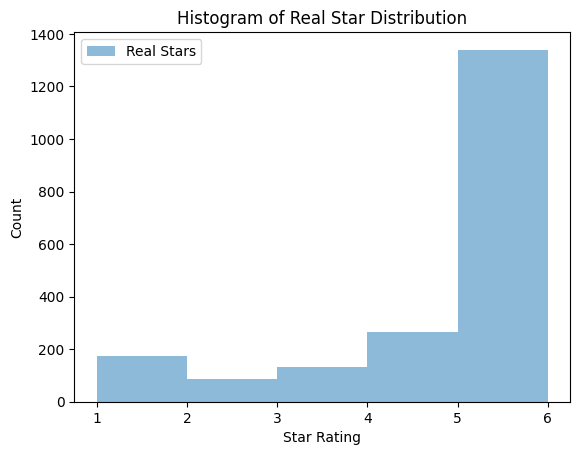

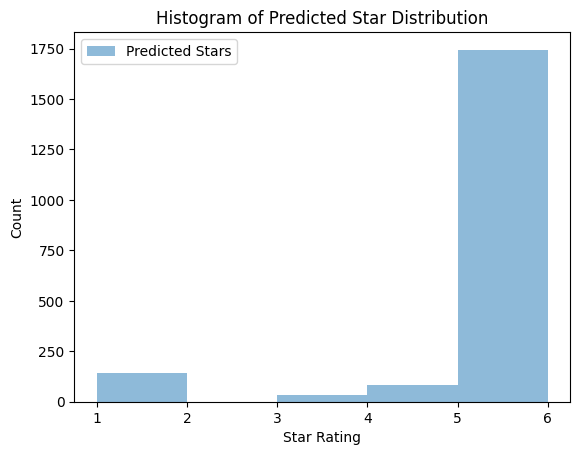

In [46]:
import matplotlib.pyplot as plt

# Plot the histogram of real star distribution
plt.hist(y_test, bins=5, range=(1, 6), alpha=0.5, label='Real Stars')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Histogram of Real Star Distribution')
plt.legend()
plt.show()

# Plot the histogram of predicted star distribution
plt.hist(predictions, bins=5, range=(1, 6), alpha=0.5, label='Predicted Stars')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Histogram of Predicted Star Distribution')
plt.legend()
plt.show()


In [50]:
print(len(y_test.loc[y_test == 1]))
print(len(y_test.loc[y_test == 2]))
print(len(y_test.loc[y_test == 3]))
print(len(y_test.loc[y_test == 4]))
print(len(y_test.loc[y_test == 5]))

185
92
101
254
1368


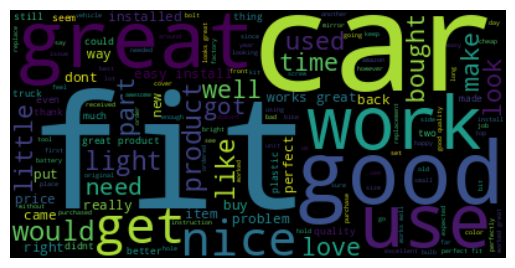

In [51]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

textt = " ".join(review for review in trunc['review_body'])
wordcloud = WordCloud(stopwords=stopwords.words()).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
print(stopwords)

<WordListCorpusReader in 'C:\\Users\\Qcoret\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>


In [19]:
def readFile(fileName):
  #Reads the file, the proper encoding is to prevent problems
  return pd.read_csv(fileName, encoding="utf−8")

In [21]:
punctuation = string.punctuation

def cleanData(data):
  #Replace missing data with "" in product_title
  data["product_title"] = data["product_title"].fillna("")

  n = len(data["review_body"])
  #for i in np.arange(n):
  #  data["review_body"][i] = BeautifulSoup(data["review_body"][i], "html.parser")

  #Remove the capital letters to prevent miscounting the frequency of words
  data["review_body"] = data["review_body"].str.lower()

  #Remove punctuation so that we can later split the data properly into words by only consider spaces
  data["review_body"] = data["review_body"].apply(lambda data: removePunctuation(data))

  testData = data["review_body"][0:100]
 
  stopwords = set(stopwords.words("english"))
  doc_string = testData.loc[0, "text"]
  print(doc_string)
  


def removePunctuation(text):
    return text.translate(str.maketrans('', '', punctuation))


In [22]:
def main():
  file = readFile("group_8_automotive_data.csv")
  #print(file.head())

  #Results below show that approximately all data is inserted,
  #except for product_title where approximately 0.0015% is missing
  #print(file.isnull().mean())

  #All variables are intepreted as 'object', except for 'customer_id' and 'star_rating' which are seen as 'int64'. This is fine if we consider the data

  #print(file.dtypes)

  #print(file.min())
  #print(file.max())


  cleanData(file)

main()

UnboundLocalError: local variable 'stopwords' referenced before assignment